In [1]:
cd ..

/workspaces/rag-stock-forecasting


In [2]:
import os
import pandas as pd
import numpy as np
from glob import glob

DATA_DIR = "data/company_dataset_patched"
FILES = glob(f"{DATA_DIR}/*.csv")

print("Found files:", [os.path.basename(f) for f in FILES])

Found files: ['AAPL.csv', 'NVDA.csv', 'QCOM.csv', 'MSFT.csv', 'GOOGL.csv', 'TSM.csv', 'TXN.csv', 'ASML.csv', 'AMD.csv', 'AVGO.csv']


In [3]:
def preprocess_company(path):
    df = pd.read_csv(path, parse_dates=["date"])
    df.sort_values("date", inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Create continuous full date index
    full_index = pd.date_range(df["date"].min(), df["date"].max(), freq="D")
    df = df.set_index("date").reindex(full_index)
    df.index.name = "date"

    # Add trading day indicator
    df["is_trading_day"] = (~df["close"].isna()).astype(int)

    # Forward-fill fundamentals + macro features only
    # DO NOT forward-fill price data
    fundamental_cols = [
        "revenue", "net_income", "operating_income", "gross_profit",
        "total_assets", "total_liabilities", "long_term_debt",
        "cash_and_equivalents", "operating_cashflow", "capital_expenditures",
        "real_gdp", "real_gdp_per_capita", "cpi", "inflation", "unemployment",
        "federal_funds_rate", "retail_sales", "treasury_yield_10y"
    ]

    df[fundamental_cols] = df[fundamental_cols].ffill()

    # Symbol column still NaN on weekends → forward fill it
    df["symbol"] = df["symbol"].ffill()

    return df


In [4]:
cleaned = {}
for f in FILES:
    sym = os.path.basename(f).replace(".csv", "")
    print(f"Processing {sym}...")
    cleaned[sym] = preprocess_company(f)

Processing AAPL...
Processing NVDA...
Processing QCOM...
Processing MSFT...
Processing GOOGL...
Processing TSM...
Processing TXN...
Processing ASML...
Processing AMD...
Processing AVGO...


In [5]:
df_all = pd.concat(cleaned.values(), axis=0)
df_all.sort_index(inplace=True)

print(df_all.shape)
df_all.head()

(14580, 29)


,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,symbol,year,...,capital_expenditures,real_gdp,real_gdp_per_capita,cpi,inflation,unemployment,federal_funds_rate,retail_sales,treasury_yield_10y,is_trading_day
date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,133.52,133.6116,126.7600,129.41,125.987713,143301887.0,0.0,1.0,AAPL,2021.0,...,2.269000e+09,22075.931,65770.0,281.148,8.0028,4.0,0.08,505782.0,1.76,1
2021-01-04,153.01,155.1500,147.1388,148.50,133.354107,9826976.0,0.0,1.0,QCOM,2021.0,...,4.830000e+08,22075.931,65770.0,281.148,8.0028,4.0,0.08,505782.0,1.76,1
2021-01-04,1760.00,1762.4899,1707.1400,1726.13,85.711346,1866195.0,0.0,1.0,GOOGL,2021.0,...,5.942000e+09,22075.931,65770.0,281.148,8.0028,4.0,0.08,505782.0,1.76,1
2021-01-04,111.47,114.1000,110.4450,111.70,102.994098,11262137.0,0.0,1.0,TSM,2021.0,...,2.498094e+11,22075.931,65770.0,281.148,8.0028,4.0,0.08,505782.0,1.76,1
2021-01-04,164.60,167.8400,160.7550,162.22,140.804380,4659971.0,0.0,1.0,TXN,2021.0,...,3.080000e+08,22075.931,65770.0,281.148,8.0028,4.0,0.08,505782.0,1.76,1


In [6]:
corr = df_all.select_dtypes(include=[np.number]).corr()
corr.shape

(28, 28)

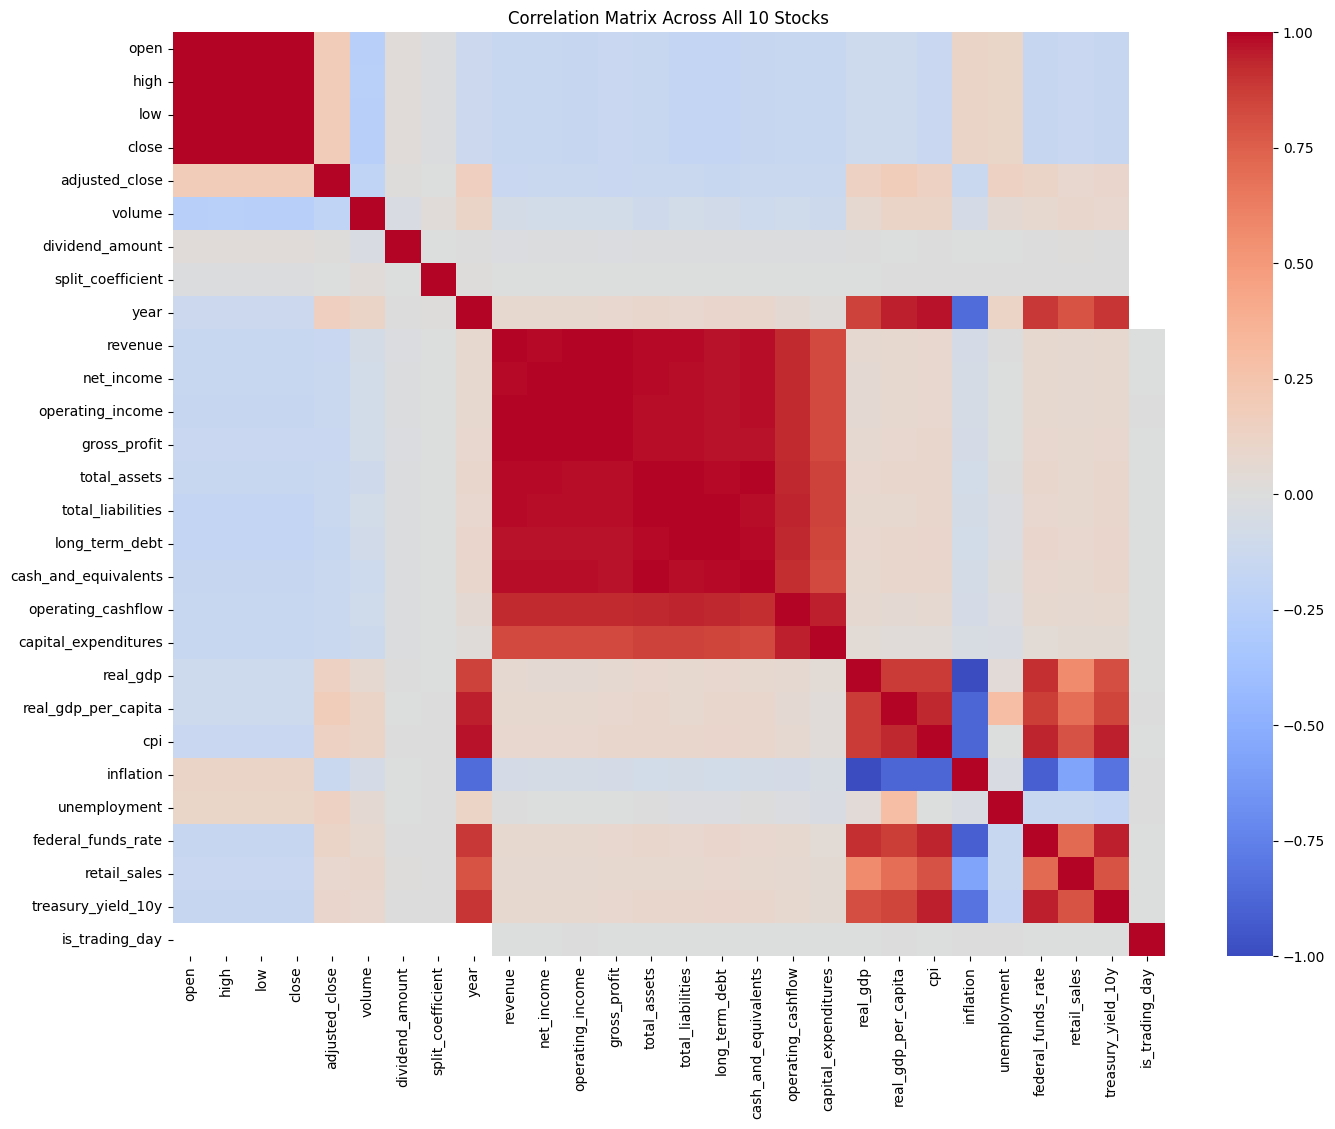

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,12))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Matrix Across All 10 Stocks")
plt.show()


In [8]:
import pandas as pd
import numpy as np
import os

OUT_DIR = "data/processed_company_dataset"
os.makedirs(OUT_DIR, exist_ok=True)

def engineer_features_robust(df):
    """
    Robust Feature Engineering with proper Weekend Handling.
    """
    # Ensure sorted index
    df = df.sort_index().copy()

    # --------------------------
    # 1. EXPAND TO CALENDAR DAYS (Handling Weekends)
    # --------------------------
    # We reindex to full calendar first so lags are true time lags
    start_date = df.index.min()
    end_date = df.index.max()
    full_idx = pd.date_range(start_date, end_date, freq='D')
    
    # Save 'is_trading_day' flag
    df['is_trading_day'] = 1.0
    
    # Reindex
    df = df.reindex(full_idx)
    
    # --------------------------
    # 2. FILL MISSING DATA (The Critical Fix)
    # --------------------------
    # A. Volume is 0 on weekends
    df['volume'] = df['volume'].fillna(0.0)
    
    # B. Trading Day flag is 0 on weekends
    df['is_trading_day'] = df['is_trading_day'].fillna(0.0)
    
    # C. Prices & Fundamentals & Macro -> FORWARD FILL
    # This prevents the "Zero Crash" on Saturday
    cols_to_ffill = [
        'close', 'revenue', 'net_income', 'inflation', 'unemployment', 
        'federal_funds_rate', 'treasury_yield_10y'
    ]
    df[cols_to_ffill] = df[cols_to_ffill].ffill()

    # --------------------------
    # 3. LAG FEATURES (Calendar Days)
    # --------------------------
    # 60 days = ~2 months. 90 days = ~1 Quarter.
    # Since we are on Calendar Days now, use 90 for quarters.
    df['revenue_lag']      = df['revenue'].shift(90)
    df['net_income_lag']   = df['net_income'].shift(90)
    df['inflation_lag']    = df['inflation'].shift(30)
    df['unemployment_lag'] = df['unemployment'].shift(30)

    # --------------------------
    # 4. TECHNICALS
    # --------------------------
    # Log Return (Daily)
    # On weekends, Close_t == Close_t-1 (due to ffill), so LogRet = 0. Correct.
    df['log_ret'] = np.log(df['close'] / df['close'].shift(1)).fillna(0.0)

    # Volatility (20 Day Rolling)
    df['volatility_20d'] = df['log_ret'].rolling(20).std()

    # Volume Change
    vol_ma = df['volume'].rolling(20).mean()
    df['volume_change'] = (df['volume'] - vol_ma) / (vol_ma + 1e-6)

    # --------------------------
    # 5. VALUATION (Ratios)
    # --------------------------
    # Since we ffilled 'close' and 'revenue', this ratio stays constant on weekends.
    # This is exactly what we want (no crash).
    df['ps_ratio'] = df['close'] / (df['revenue_lag'] + 1e-6)
    df['pe_ratio'] = df['close'] / (df['net_income_lag'] + 1e-6)

    # --------------------------
    # 6. GROWTH
    # --------------------------
    # QoQ Growth (90 calendar days)
    df['rev_growth_qoq'] = df['revenue_lag'].pct_change(90)

    # --------------------------
    # 7. MACRO
    # --------------------------
    df['real_rate'] = df['federal_funds_rate'] - df['inflation_lag']
    df['yield_curve'] = df['treasury_yield_10y'] - df['federal_funds_rate']
    df['unemployment_change'] = df['unemployment_lag'].pct_change(30)

    # --------------------------
    # 8. CLEANUP & SELECT
    # --------------------------
    FINAL_FEATURES = [
        'log_ret', 'volatility_20d', 'volume_change',
        'ps_ratio', 'pe_ratio',
        'rev_growth_qoq',
        'real_rate', 'yield_curve', 'unemployment_change',
        'close', 'is_trading_day'
    ]

    # Trim warmup period (First 130 days needed for lags/rolling)
    # But only drop if it's NaN.
    df_clean = df[FINAL_FEATURES].copy()
    
    # Handle infinities
    df_clean = df_clean.replace([np.inf, -np.inf], np.nan)
    
    # Drop rows that are still NaN (the warmup period)
    df_clean = df_clean.dropna()

    # Restore Metadata columns
    df_clean['date'] = df_clean.index
    # We lost 'symbol' during reindex, assume caller handles it or we map it back
    # df_clean['symbol'] = ... (Handled in loop below)

    return df_clean

# ====================================================
# PROCESS LOOP
# ====================================================
# Assuming 'cleaned' dictionary exists from previous steps
# cleaned = { 'AAPL': df_aapl, ... }

for sym, df in cleaned.items():
    print(f"Processing {sym}...")
    
    # Ensure Date Index
    if 'date' in df.columns:
        df = df.set_index('date')
    df.index = pd.to_datetime(df.index)
    
    # Process
    df_feat = engineer_features_robust(df)
    
    # Add Symbol back
    df_feat['symbol'] = sym
    
    # Reorder
    cols = ['date', 'symbol'] + [c for c in df_feat.columns if c not in ['date', 'symbol']]
    df_feat = df_feat[cols]
    
    # Save
    out_path = f"{OUT_DIR}/{sym}.csv"
    df_feat.to_csv(out_path, index=False)
    print(f"Saved {len(df_feat)} rows.")

Processing AAPL...
Saved 1278 rows.
Processing NVDA...
Saved 1278 rows.
Processing QCOM...
Saved 1278 rows.
Processing MSFT...
Saved 1278 rows.
Processing GOOGL...
Saved 1278 rows.
Processing TSM...
Saved 1278 rows.
Processing TXN...
Saved 1278 rows.
Processing ASML...
Saved 1278 rows.
Processing AMD...
Saved 1278 rows.
Processing AVGO...
Saved 1278 rows.
